In [2]:
import ultralytics

In [3]:
ultralytics.checks()

Ultralytics YOLOv8.0.51 🚀 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Setup complete ✅ (8 CPUs, 15.6 GB RAM, 66.1/1006.9 GB disk)


In [4]:
model = ultralytics.YOLO('models/yolov8s-blood-cell-detection.pt')

In [12]:
results = model.predict('data/agar/dataset/12995.jpg')


image 1/1 /mnt/d/projects/colony/data/agar/dataset/12995.jpg: 640x640 (no detections), 107.2ms
Speed: 2.0ms preprocess, 107.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [17]:
image = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'
results = model.predict(image)


Found https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg locally at zidane.jpg
image 1/1 /mnt/d/projects/colony/zidane.jpg: 384x640 1 RBC, 115.0ms
Speed: 1.5ms preprocess, 115.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


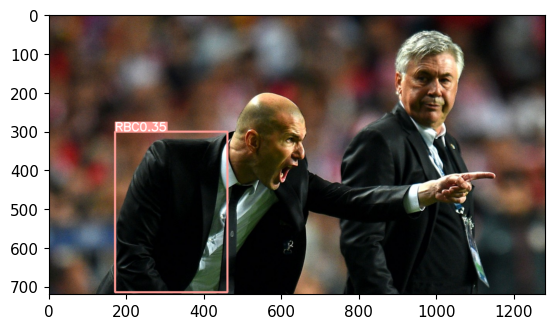

In [18]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [29]:
import json
import os
import pathlib


# Expected format for the label files is image000.txt with rows of:
# class_number box1_x1_ratio box1_y1_ratio box1_width_ratio box1_height_ratio
def convert_json_to_txt_label(label_dict, image_width, image_height, class_dict, default_class=0):
    class_label = class_dict.get(label_dict['class']) or default_class
    return [class_label, 
            label_dict['x'] / image_width,
            label_dict['y'] / image_height,
            label_dict['width'] / image_width,
            label_dict['height'] / image_height,
            ]


In [30]:
# Setup the location for the AGAR dataset.

DATA_PATH = 'data/agar/dataset/'

In [31]:
# Determine unique labels from dataset.
label_set = set([])

for c, file_path in enumerate(pathlib.Path(DATA_PATH).glob('*.json')):
    if c % 1000 == 0:
        print(f'Files opened: {c}')
    with open(file_path, 'r') as f:
        json_dict = json.loads(f.read())
        label_set.update(json_dict['classes'])

with open(os.path.join(DATA_PATH, 'labels.txt')) as f:
    for c, label in enumerate(label_set):
        f.write(f'{c+1}:{label}\n')

AttributeError: 'str' object has no attribute '_flavour'

In [26]:
s = set([])
s.add()

In [25]:

pathlib.Path.glob()